In [2]:
!conda install -c conda-forge pyrender trimesh imageio -y

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/s5701147/.pyenv/versions/anaconda3-2024.06-1

  added / updated specs:
    - imageio
    - pyrender
    - trimesh


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.4.26  |       hbd8a1cb_0         149 KB  conda-forge
    certifi-2025.4.26          |     pyhd8ed1ab_0         154 KB  conda-forge
    conda-24.11.3              |  py312h7900ff3_0         1.1 MB  conda-forge
    dataclasses-0.8            |     pyhc8e2a94_3          10 KB  conda-forge
    ffmpeg-4.4.0               |       h6987444_4         9.9 MB  conda-forge
    fontconfig-2.14.2          |       h14ed4e7_0         266 KB  conda-forge
    freetype-py-2.5.1          |     pyhd8ed1ab_1          64 KB  conda-forge
    gmp-6.2.1                  |       h58526e2_0         806

In [1]:
import numpy as np
import pyrender
import trimesh
import imageio
import os
import json
import math

In [2]:
def makedir(path):
    folder = os.path.exists(path)
    if not folder:
        os.mkdir(path)

In [3]:
def clamp(value, min_value, max_value):
    return max(min_value, min(value, max_value))

def angle_between(v1, v2):
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_v1, unit_v2)
    angle_rad = np.arccos(clamp(dot_product, -1.0, 1.0))  # Clamp to avoid floating point errors
    return angle_rad

def compute_scale(fov, aspect):
    # This is a placeholder calculation for Sx and Sy based on typical perspective projection
    Sx = 1.0 / np.tan(fov * 0.5)  # Assuming fov is in radians
    Sy = Sx * aspect
    return Sx, Sy

def get_alpha(fov, aspect, pA, pB):
    Sx, Sy = compute_scale(fov, aspect)
    # Assuming pA and pB are tuples (x, y), and we just need their screen space projection
    pA3 = np.array([pA[0] / Sx, pA[1] / Sy, 1.0])
    pB3 = np.array([pB[0] / Sx, pB[1] / Sy, 1.0])
    # Calculate the angle in radians between the two vectors
    angle_rad = angle_between(pA3, pB3)
    # Clamp the angle value to the range (0.001, PI - 0.001)
    alpha = clamp(angle_rad, 0.001, np.pi - 0.001)
    return alpha

def compute_distance_from_A(AB, alpha, theta):
    return (AB * math.sin(alpha + theta / 2.0)) / math.sin(alpha)

In [4]:
# Toric→3D Position
from scipy.spatial.transform import Rotation as R
def toric2euclidean(camera_toric, wposA, wposB):
    ldxy = (camera_toric["L2Dy"] + camera_toric["R2Dy"]) / 2.0
    alpha = get_alpha(camera_toric["FOV"], camera_toric["Aspect"], [camera_toric["L2Dx"], camera_toric["L2Dy"]],
                      [camera_toric["R2Dx"], camera_toric["R2Dy"]])
    theta = camera_toric["Theta"]
    phi = camera_toric["Phi"]

    vecAB = wposB - wposA
    AB = np.linalg.norm(vecAB)

    n = vecAB
    n2 = np.array([vecAB[0], vecAB[2]])  # Project onto Y plane
    n2 = np.array([-n2[1], n2[0]])  # Rotate 90 degrees in the Y plane
    z = np.array([n2[0], 0, n2[1]])  # Unproject

    vecABnorm = n / np.linalg.norm(n)
    qP = R.from_rotvec(phi * vecABnorm)  # Rotation around vecABnorm by phi
    beta = theta / 2

    t = np.cross(z, n)
    # t = t / np.linalg.norm(t)
    qT = R.from_rotvec(beta * t)  # Rotation around t by beta
    d = compute_distance_from_A(AB, alpha, theta)

    if alpha <= 0.01 and theta > 5.0:
        d = 0.0

    res = qP.apply(qT.apply(vecAB))  # Apply qT to vecAB and then apply qP to the result
    res *= d
    res /= AB
    print("result:", res)
    res += wposA
   #输出 ：该帧相机的 3D 世界位置
    return res

#Toric→Rotation Frame5
def toric2rotation(camera_toric, cam_pos, wposA, wposB):
    ldxy = (camera_toric["L2Dy"] + camera_toric["R2Dy"]) / 2.0
    alpha = get_alpha(camera_toric["FOV"], camera_toric["Aspect"],
                      [camera_toric["L2Dx"], camera_toric["L2Dy"]],
                      [camera_toric["R2Dx"], camera_toric["R2Dy"]])
    Sx, Sy = compute_scale(camera_toric["FOV"], camera_toric["Aspect"])
    pA3 = np.array([camera_toric["L2Dx"] / Sx, ldxy / Sy, 1.0])
    pB3 = np.array([camera_toric["R2Dx"] / Sx, ldxy / Sy, 1.0])
    pA3 = pA3 / np.linalg.norm(pA3)
    pB3 = pB3 / np.linalg.norm(pB3)

    fwd = pA3 + pB3
    fwd = fwd / np.linalg.norm(fwd)
    up = np.cross(pA3, pB3)
    up = up / np.linalg.norm(up)
    right = np.cross(fwd, up)
    right = right / np.linalg.norm(right)
    up = np.cross(right, fwd)
    up = up / np.linalg.norm(up)

    pA4 = wposA - cam_pos
    pB4 = wposB - cam_pos
    pA4 = pA4 / np.linalg.norm(pA4)
    pB4 = pB4 / np.linalg.norm(pB4)
    fwd2 = pA4 + pB4
    fwd2 = fwd2 / np.linalg.norm(fwd2)
    up2 = np.array([0.0, 1.0, 0.0])
    right2 = np.cross(fwd2, up2)
    right2 = right2 / np.linalg.norm(right2)
    up2 = np.cross(right2, fwd2)
    up2 = up2 / np.linalg.norm(up2)

    # Create rotation matrices
    rotation_matrix = np.column_stack((right, up, fwd))
    rotation_matrix2 = np.column_stack((right2, up2, fwd2))

    # Compute the inverse of the first rotation matrix
    inverse_rotation_matrix = np.linalg.inv(rotation_matrix)

    # Apply the inverse rotation to the second set of axes
    new_axes = rotation_matrix2 @ inverse_rotation_matrix

    new_right = new_axes[:, 0]
    new_up = new_axes[:, 1]
    new_fwd = new_axes[:, 2]

    rot_trans = np.eye(4)
    rot_trans[0, :3] = new_right
    rot_trans[1, :3] = new_up
    rot_trans[2, :3] = new_fwd

    return (rot_trans[0][:3], rot_trans[1][:3], rot_trans[2][:3])

In [5]:
#Camera Frustum Visualization
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

def draw_camera_viewing_cone(ax, camera_cur_pos, rot_trans, rotation_up, fov=30.0, aspect=1.67/2.5, near=0.0, far=2.0):
    global camera_path
    # Calculate the half-angles of the FOV
    half_fov = np.deg2rad(fov) / 2.0
    half_horizontal_fov = 2 * np.arctan(np.tan(half_fov) * aspect)

    # Calculate the near and far plane dimensions
    near_height = 2 * np.tan(half_fov) * near
    near_width = 2 * np.tan(half_horizontal_fov) * near
    far_height = 2 * np.tan(half_fov) * far
    far_width = 2 * np.tan(half_horizontal_fov) * far

    # Transform the frustum corners by the transformation matrix
    transformed_corners = np.array([
        camera_cur_pos + rot_trans[0] *  near_width / 2 + rot_trans[1] * near_height / 2 + rot_trans[2] * near,
        camera_cur_pos - rot_trans[0] *  near_width / 2 + rot_trans[1] * near_height / 2 + rot_trans[2] * near,
        camera_cur_pos - rot_trans[0] *  near_width / 2 - rot_trans[1] * near_height / 2 + rot_trans[2] * near,
        camera_cur_pos + rot_trans[0] *  near_width / 2 - rot_trans[1] * near_height / 2 + rot_trans[2] * near,
        camera_cur_pos + rot_trans[0] *  far_width / 2 + rot_trans[1] * far_height / 2 + rot_trans[2] * far,
        camera_cur_pos - rot_trans[0] *  far_width / 2 + rot_trans[1] * far_height / 2 + rot_trans[2] * far,
        camera_cur_pos - rot_trans[0] *  far_width / 2 - rot_trans[1] * far_height / 2 + rot_trans[2] * far,
        camera_cur_pos + rot_trans[0] *  far_width / 2 - rot_trans[1] * far_height / 2 + rot_trans[2] * far,
    ])
    
    for i, pos in enumerate(transformed_corners):
        transformed_corners[i] = rotation_up.apply(pos)
        
    transformed_corners = transformed_corners[:,[0,2,1]]
    # Define the edges connecting the corners
    edges = [
        [transformed_corners[i] for i in [0,1,2,3,0]], # Near plane
        [transformed_corners[i] for i in [4,5,6,7,4]], # Far plane
        [transformed_corners[i] for i in [0,4]], # Side edges
        [transformed_corners[i] for i in [1,5]],
        [transformed_corners[i] for i in [2,6]],
        [transformed_corners[i] for i in [3,7]]
    ]

    # Draw the edges
    for edge in edges:
        ax.add_collection3d(Line3DCollection([edge], colors='k', linewidths=1.0, linestyles=':', alpha=0.05))

    # Optionally, draw the planes using a semi-transparent polygon
    planes = [
        [transformed_corners[i] for i in [0,1,2,3]], # Near plane
        [transformed_corners[i] for i in [4,5,6,7]], # Far plane
        [transformed_corners[i] for i in [0,1,5,4]], # Top plane
        [transformed_corners[i] for i in [2,3,7,6]], # Bottom plane
        [transformed_corners[i] for i in [0,3,7,4]], # Right plane
        [transformed_corners[i] for i in [1,2,6,5]]  # Left plane
    ]

    # Draw semi-transparent planes
    ax.add_collection3d(Poly3DCollection(planes, facecolors='cyan', linewidths=0.2, edgecolors='g', alpha=0.05))


In [6]:
def calculate_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def predict_shot_type(camera_pos, left_character, right_character):
    # Calculate the midpoint between the two characters
    midpoint = (left_character + right_character) / 2

    # Calculate the distance between the camera and the midpoint
    distance = calculate_distance(camera_pos, midpoint)
    # print(distance)

    # Define thresholds for shot types (these values are arbitrary and may need adjustment)
    close_up_threshold = 1.0  # Assuming the scene units are in meters
    medium_shot_threshold = 3.0

    # Classify the shot type
    if distance <= close_up_threshold:
        return "Close-up"
    elif distance <= medium_shot_threshold:
        return "Medium shot"
    else:
        return "Long shot"

result: [2.04001766 0.9203018  2.96418603]
156.1954679153462
result: [2.04001766 0.9203018  2.96418603]


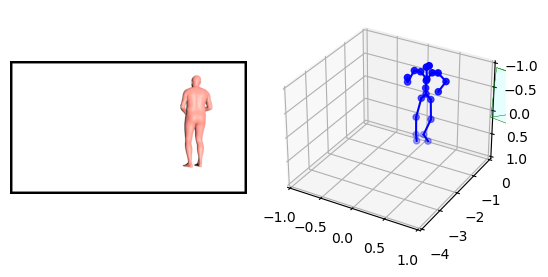

1
result: [1.95489627 0.92528383 3.00785688]
157.3600322686052
result: [1.95489627 0.92528383 3.00785688]


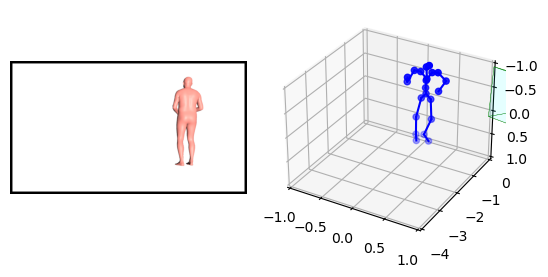

2
result: [1.82213884 0.93151796 3.06942878]
159.05521487824618
result: [1.82213884 0.93151796 3.06942878]


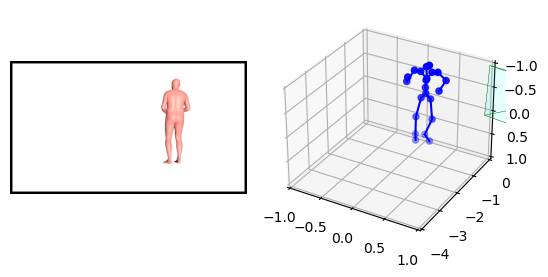

3
result: [1.56675545 0.93766241 3.17137234]
161.88355538848518
result: [1.56675545 0.93766241 3.17137234]


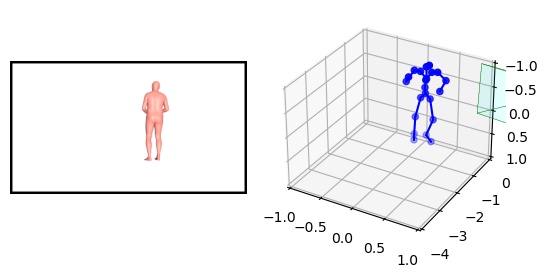

4
result: [1.01557388 0.93262768 3.32590985]
165.45005525544656
result: [1.01557388 0.93262768 3.32590985]


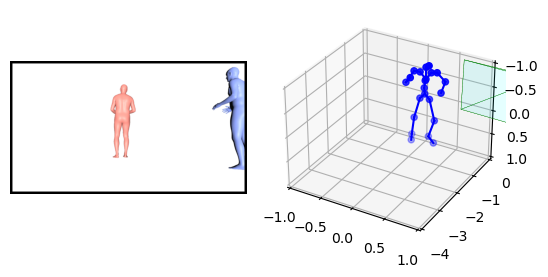

5
result: [0.2396739  0.89151479 3.39646485]
163.06693668567135
result: [0.2396739  0.89151479 3.39646485]


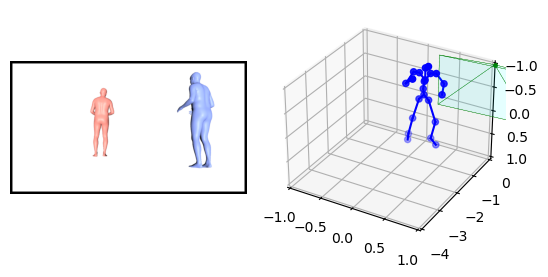

6
result: [-0.35371989  0.83100551  3.33336373]
157.29434835305224
result: [-0.35371989  0.83100551  3.33336373]


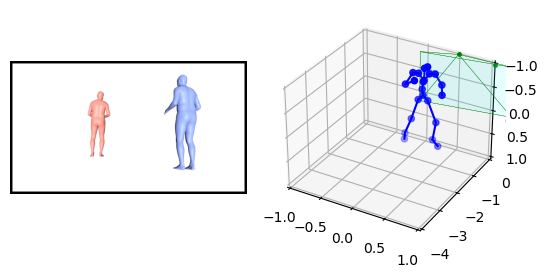

7
result: [-0.53709859  0.79775737  3.28725296]
155.3430055815913
result: [-0.53709859  0.79775737  3.28725296]


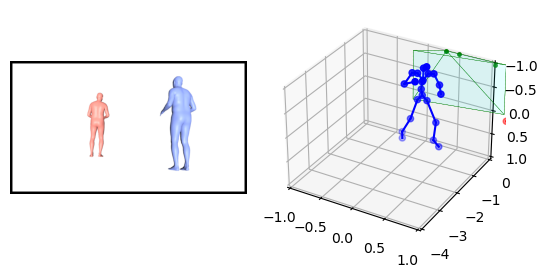

8
result: [-0.46980691  0.79309363  3.29483965]
156.46184262103267
result: [-0.46980691  0.79309363  3.29483965]


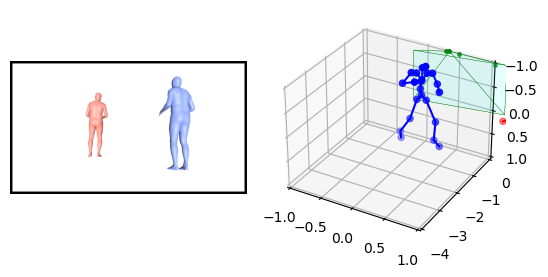

9
result: [-0.41055299  0.78992162  3.2996293 ]
157.42712170869964
result: [-0.41055299  0.78992162  3.2996293 ]


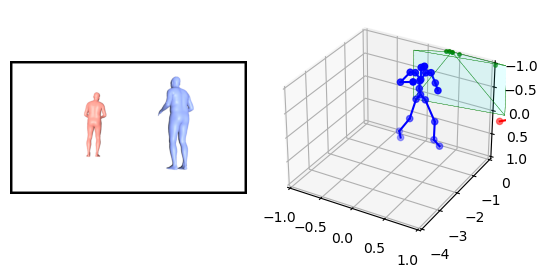

10
result: [-0.43620824  0.77968151  3.28766425]
157.30069554185638
result: [-0.43620824  0.77968151  3.28766425]


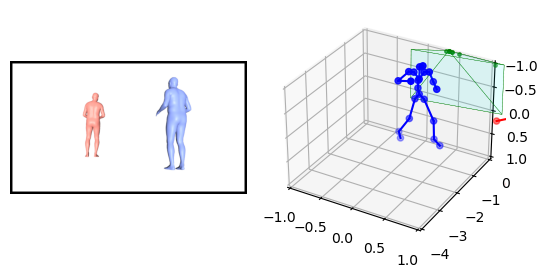

11
result: [-0.44556992  0.77388263  3.2806357 ]
157.314223354228
result: [-0.44556992  0.77388263  3.2806357 ]


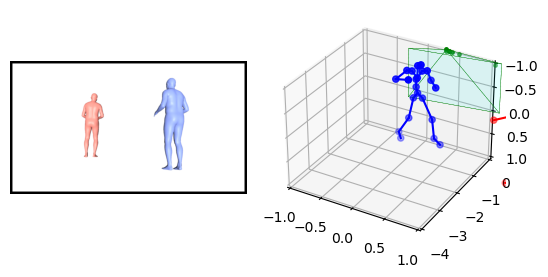

12
result: [-0.34190696  0.78183495  3.29749926]
158.66791550089937
result: [-0.34190696  0.78183495  3.29749926]


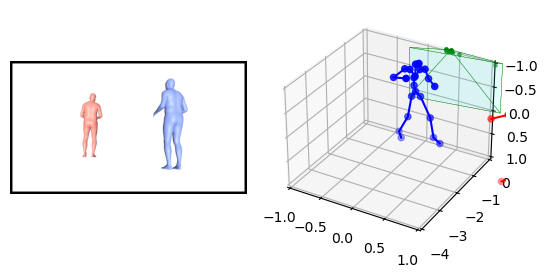

13
result: [-0.19364636  0.79346913  3.318045  ]
160.47709452138312
result: [-0.19364636  0.79346913  3.318045  ]


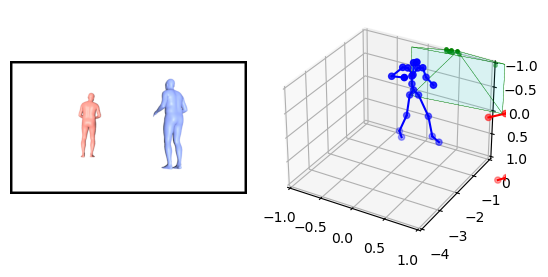

14
result: [-0.22455352  0.78407245  3.31146233]
160.26253564934177
result: [-0.22455352  0.78407245  3.31146233]


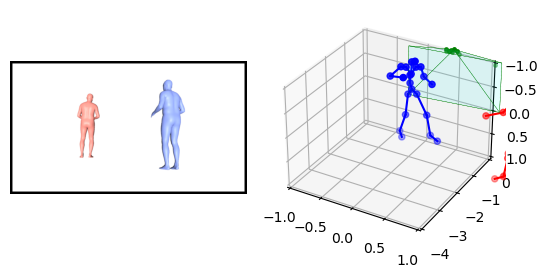

15
result: [-0.57088972  0.73486755  3.24088275]
156.21258784483
result: [-0.57088972  0.73486755  3.24088275]


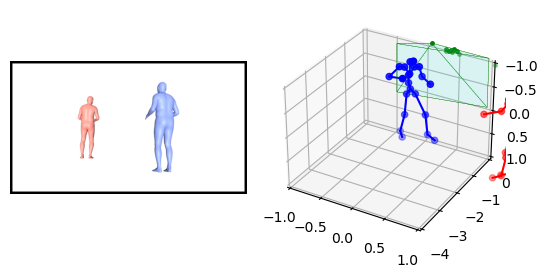

16
result: [-1.08335149  0.65377303  3.06198103]
149.2158435041967
result: [-1.08335149  0.65377303  3.06198103]


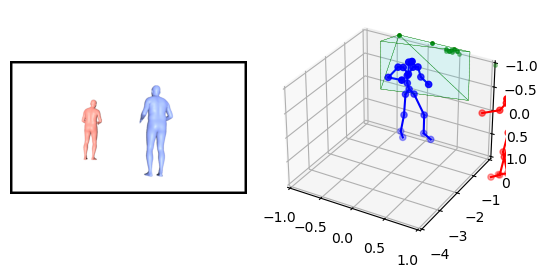

17
result: [-1.48577214  0.57794878  2.84574583]
142.9649357857904
result: [-1.48577214  0.57794878  2.84574583]


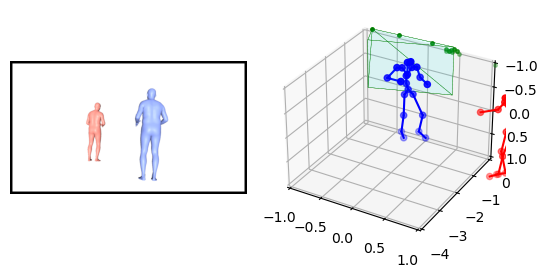

18
result: [-1.65082383  0.53888597  2.73144833]
140.21354104505062
result: [-1.65082383  0.53888597  2.73144833]


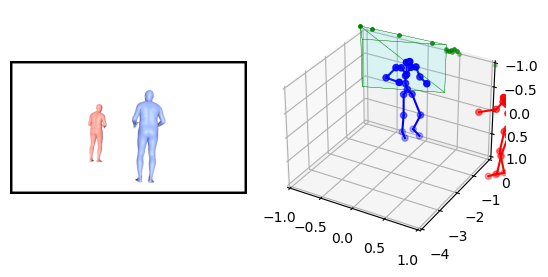

19
result: [-1.63364809  0.53350031  2.74011303]
140.62368725281664
result: [-1.63364809  0.53350031  2.74011303]


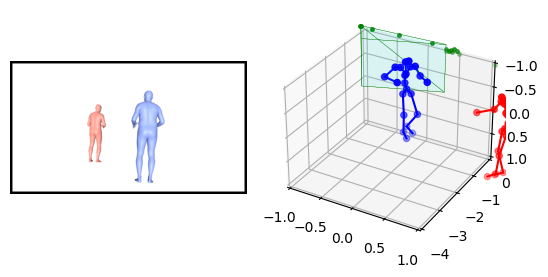

20
result: [-1.61299972  0.52454813  2.75079977]
141.1300019528813
result: [-1.61299972  0.52454813  2.75079977]


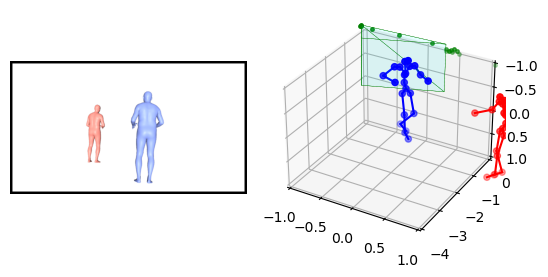

21
result: [-1.7948356   0.46267012  2.60820466]
138.02086327981888
result: [-1.7948356   0.46267012  2.60820466]


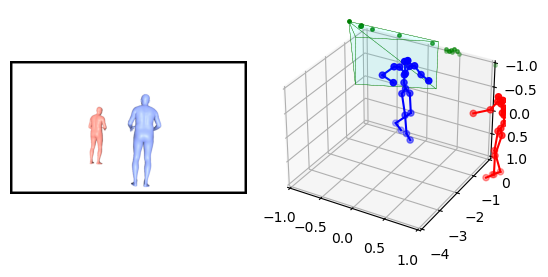

22
result: [-2.162164    0.33415521  2.24238901]
130.6168578828615
result: [-2.162164    0.33415521  2.24238901]


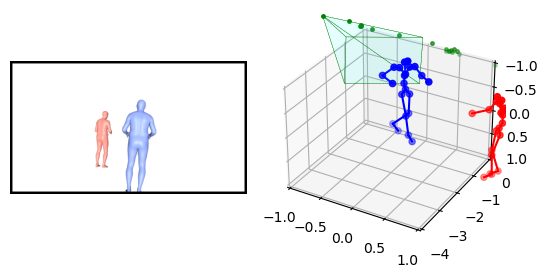

23
result: [-2.47040838  0.1905456   1.79459133]
122.61507072404495
result: [-2.47040838  0.1905456   1.79459133]


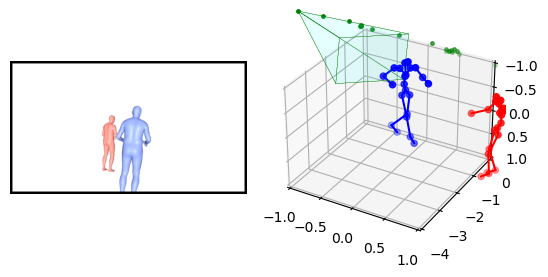

24
result: [-2.59844973  0.09406735  1.52060545]
118.20322701980729
result: [-2.59844973  0.09406735  1.52060545]


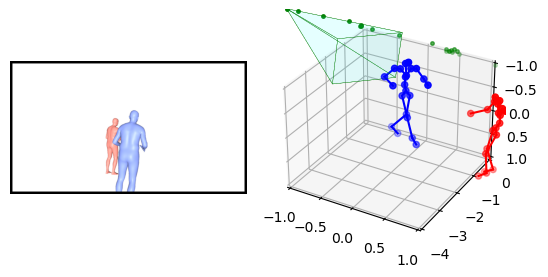

25
result: [-2.5972045   0.05668586  1.49991732]
118.19954551256482
result: [-2.5972045   0.05668586  1.49991732]


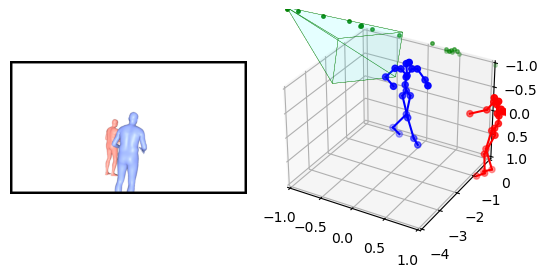

26
result: [-2.55512282  0.0434779   1.57574403]
119.7979982719062
result: [-2.55512282  0.0434779   1.57574403]


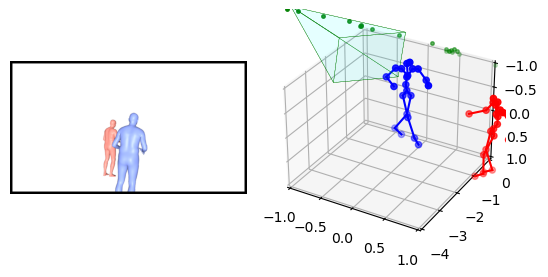

27
result: [-2.56473987  0.01033912  1.53936024]
119.39260943737688
result: [-2.56473987  0.01033912  1.53936024]


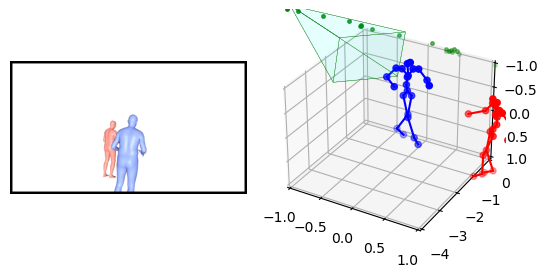

28
result: [-2.64703316 -0.0543677   1.31358962]
115.70892003722595
result: [-2.64703316 -0.0543677   1.31358962]


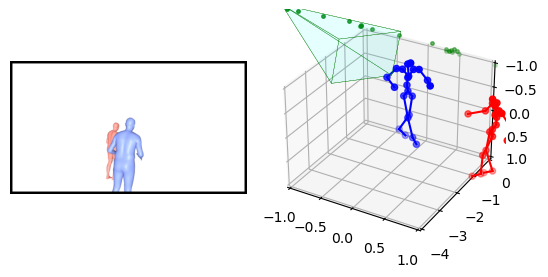

29
result: [-2.73396676 -0.12511934  0.9776563 ]
110.20848867023429
result: [-2.73396676 -0.12511934  0.9776563 ]


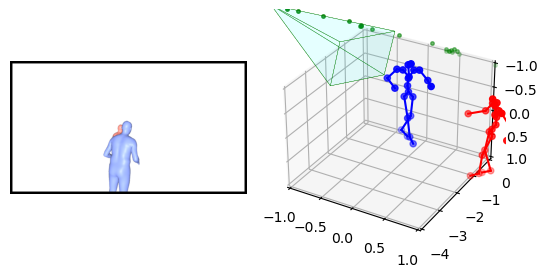

30
result: [-2.77563054 -0.16990164  0.68366802]
105.40411587779361
result: [-2.77563054 -0.16990164  0.68366802]


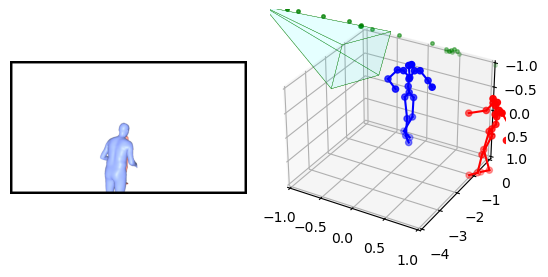

31
result: [-2.78492812 -0.17531156  0.54102281]
103.07219223068086
result: [-2.78492812 -0.17531156  0.54102281]


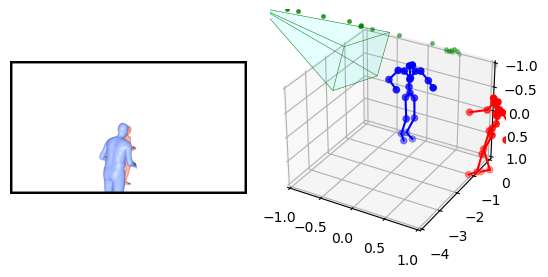

32
result: [-2.78526636 -0.15131992  0.54207282]
103.11246713400534
result: [-2.78526636 -0.15131992  0.54207282]


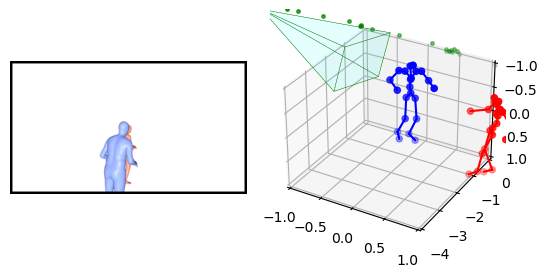

33
result: [-2.78102351 -0.1151848   0.62161331]
104.45024877560395
result: [-2.78102351 -0.1151848   0.62161331]


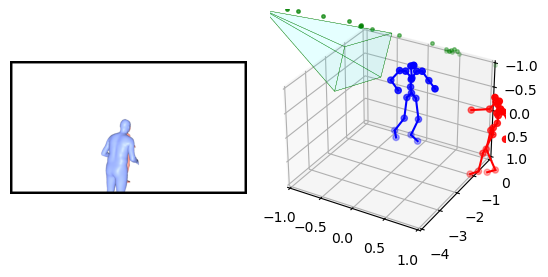

34
result: [-2.76216975 -0.06195611  0.79967484]
107.41167039751933
result: [-2.76216975 -0.06195611  0.79967484]


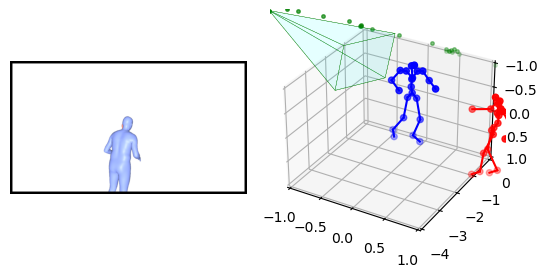

35
result: [-2.68918374  0.03055274  1.14976751]
113.21998957242542
result: [-2.68918374  0.03055274  1.14976751]


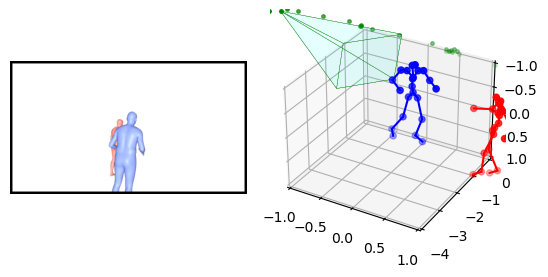

36
result: [-2.52213125  0.15320902  1.59630679]
120.76268631366473
result: [-2.52213125  0.15320902  1.59630679]


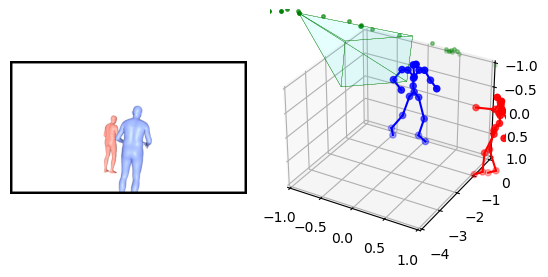

37
result: [-2.34437073  0.2504109   1.9149497 ]
126.35991960525575
result: [-2.34437073  0.2504109   1.9149497 ]


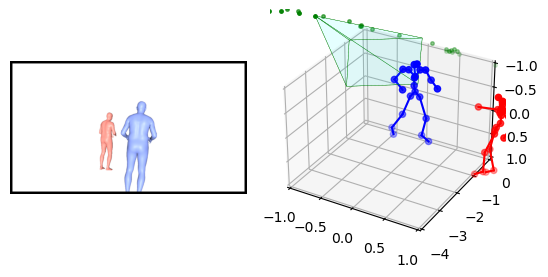

38
result: [-2.2725578   0.29042988  2.02150054]
128.26200840625356
result: [-2.2725578   0.29042988  2.02150054]


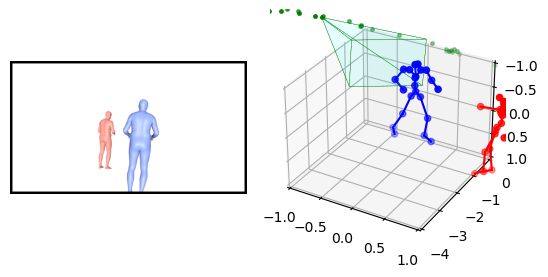

39
result: [-2.25051563  0.30561406  2.05287343]
128.80210842688993
result: [-2.25051563  0.30561406  2.05287343]


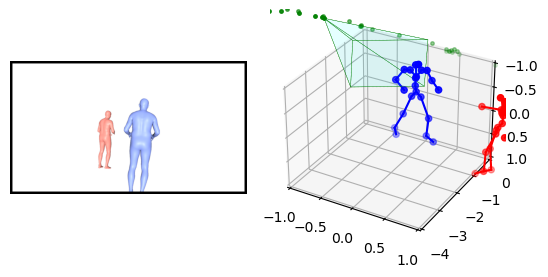

40
result: [-2.16354045  0.33997891  2.16598769]
130.92116962870253
result: [-2.16354045  0.33997891  2.16598769]


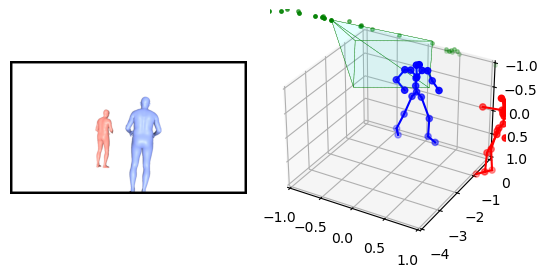

41
result: [-1.98166086  0.40056653  2.37035464]
134.9465277649877
result: [-1.98166086  0.40056653  2.37035464]


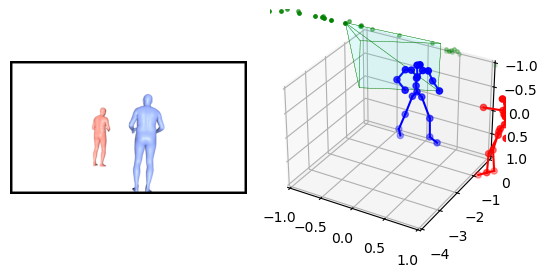

42
result: [-1.77960265  0.46025037  2.55951366]
138.92287621070423
result: [-1.77960265  0.46025037  2.55951366]


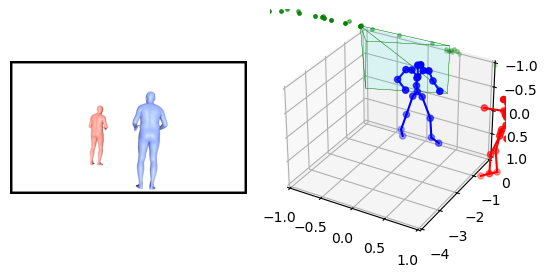

43
result: [-1.67306006  0.49103088  2.64786332]
140.8332142678856
result: [-1.67306006  0.49103088  2.64786332]


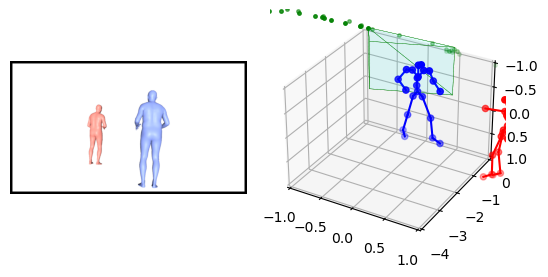

44
result: [-1.7033056   0.48704966  2.62723806]
140.23131493940636
result: [-1.7033056   0.48704966  2.62723806]


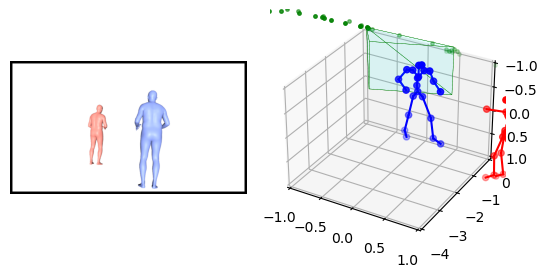

45
result: [-1.80232835  0.46522263  2.54879348]
138.34023339985933
result: [-1.80232835  0.46522263  2.54879348]


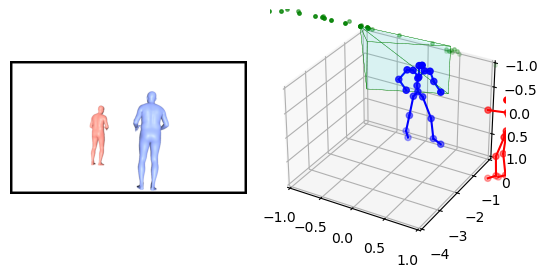

46
result: [-1.88300637  0.44708431  2.48003652]
136.7326074271963
result: [-1.88300637  0.44708431  2.48003652]


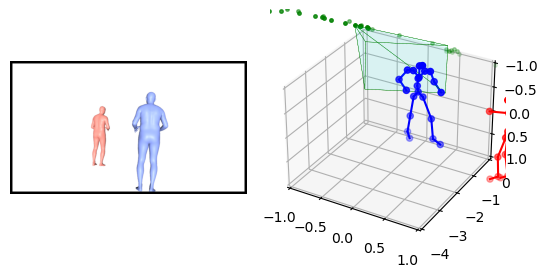

47
result: [-1.91187733  0.44184408  2.45604455]
136.11905576319316
result: [-1.91187733  0.44184408  2.45604455]


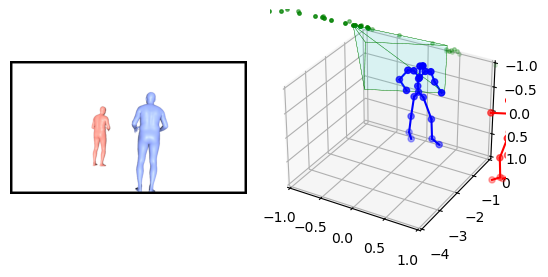

48
result: [-1.89714143  0.44726641  2.47227993]
136.3836629446498
result: [-1.89714143  0.44726641  2.47227993]


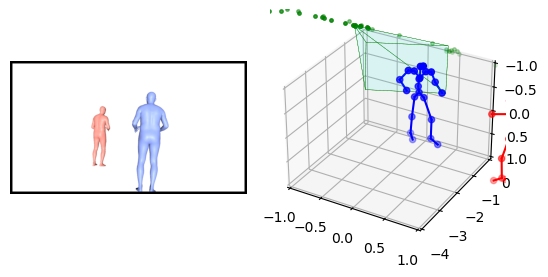

49
result: [-1.87107194  0.45445281  2.49750745]
136.8847694169401
result: [-1.87107194  0.45445281  2.49750745]


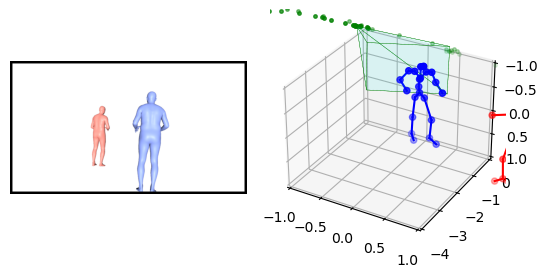

50
result: [-1.89123379  0.44840644  2.47949235]
136.48867336015493
result: [-1.89123379  0.44840644  2.47949235]


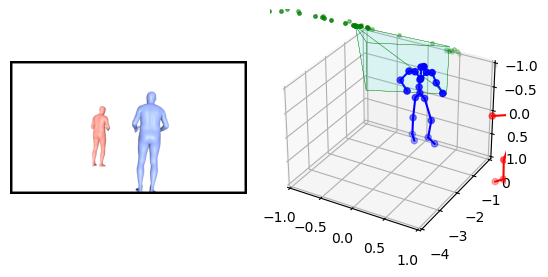

51
result: [-1.99924566  0.41630658  2.37536713]
134.2978823710446
result: [-1.99924566  0.41630658  2.37536713]


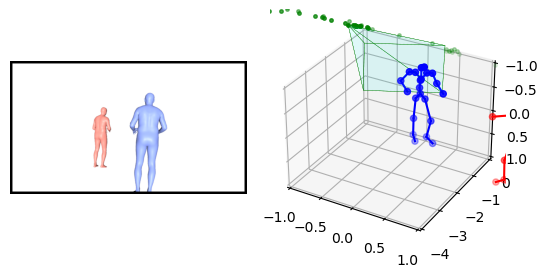

52
result: [-2.1575177   0.36389485  2.20281807]
130.81968223156946
result: [-2.1575177   0.36389485  2.20281807]


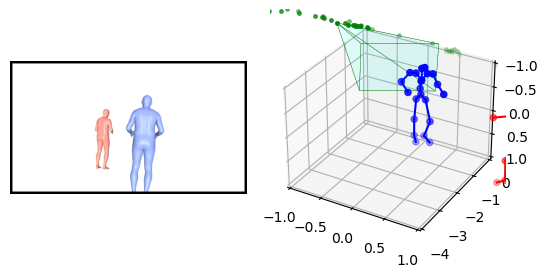

53
result: [-2.28169078  0.31602413  2.04774967]
127.80230745259777
result: [-2.28169078  0.31602413  2.04774967]


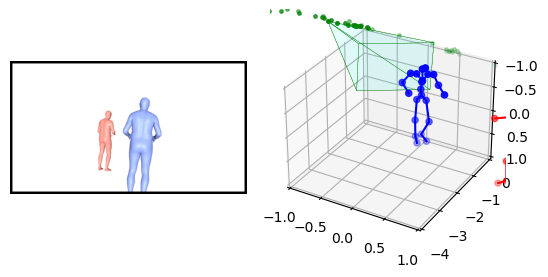

54
result: [-2.33287935  0.29224563  1.97993126]
126.4657068813231
result: [-2.33287935  0.29224563  1.97993126]


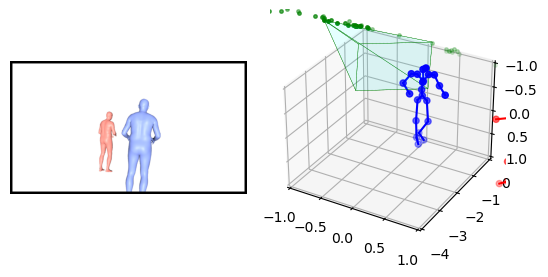

55
result: [-2.33278087  0.28974165  1.98412257]
126.46853904675322
result: [-2.33278087  0.28974165  1.98412257]


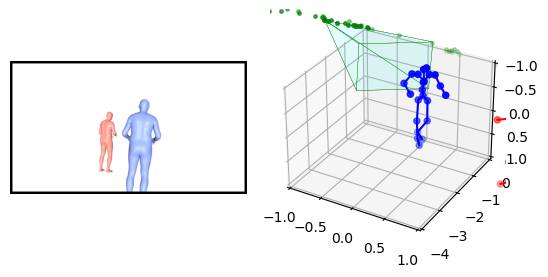

56
result: [-2.30830708  0.29856884  2.02232989]
127.10973394391388
result: [-2.30830708  0.29856884  2.02232989]


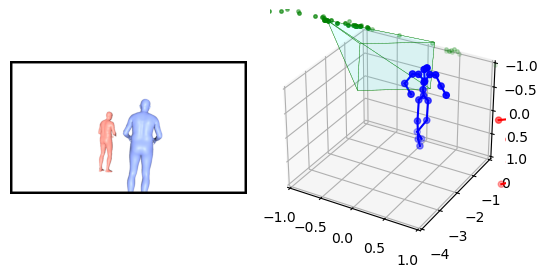

57
result: [-2.24747901  0.32084799  2.10746005]
128.64595308534382
result: [-2.24747901  0.32084799  2.10746005]


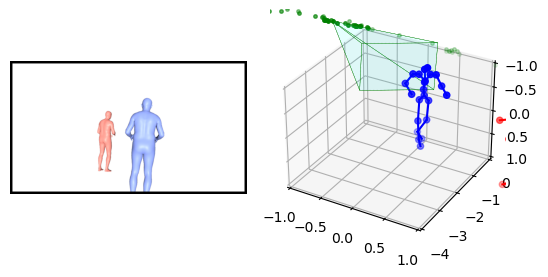

58
result: [-2.13414523  0.35898187  2.24876646]
131.31759254699978
result: [-2.13414523  0.35898187  2.24876646]


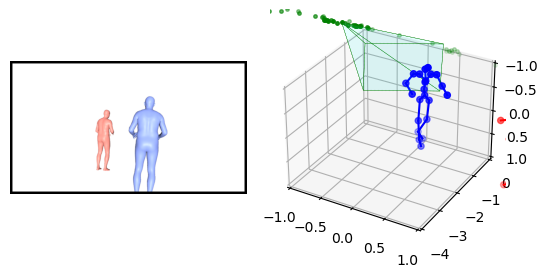

59
result: [-1.98479171  0.40466104  2.41032966]
134.53822456285621
result: [-1.98479171  0.40466104  2.41032966]


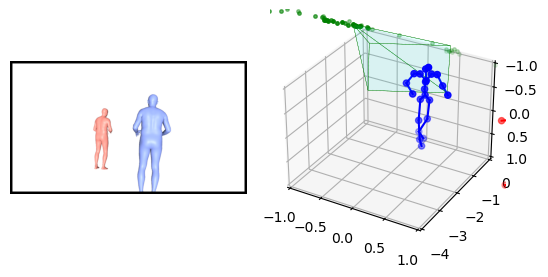

60
result: [-1.82249093  0.45039336  2.56107341]
137.7455623482572
result: [-1.82249093  0.45039336  2.56107341]


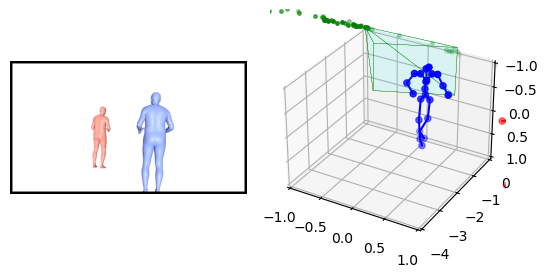

61
result: [-1.65672235  0.49432259  2.69342467]
140.77923715235636
result: [-1.65672235  0.49432259  2.69342467]


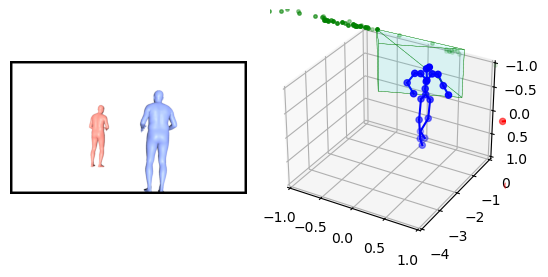

62
result: [-1.51385475  0.53058887  2.79292713]
143.2318550140204
result: [-1.51385475  0.53058887  2.79292713]


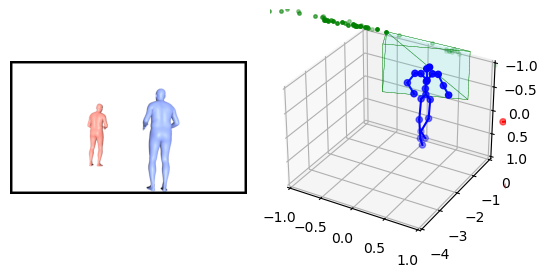

63
result: [-1.43989164  0.54971973  2.84000007]
144.4399840093153
result: [-1.43989164  0.54971973  2.84000007]


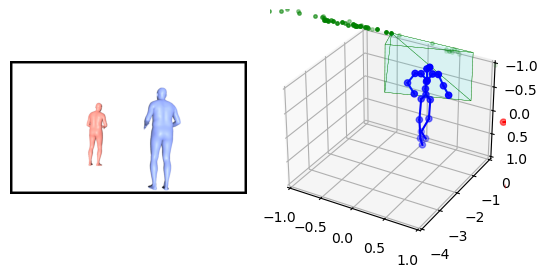

64
result: [-1.45385806  0.54909447  2.83211685]
144.18050275723922
result: [-1.45385806  0.54909447  2.83211685]


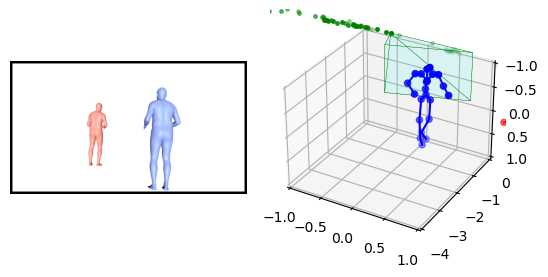

65
result: [-1.52441936  0.53638467  2.788515  ]
142.95893157555773
result: [-1.52441936  0.53638467  2.788515  ]


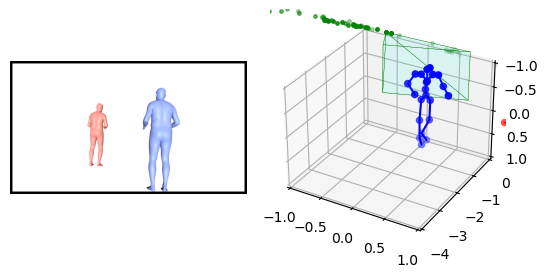

66
result: [-1.59858667  0.52373801  2.7404288 ]
141.62909411860656
result: [-1.59858667  0.52373801  2.7404288 ]


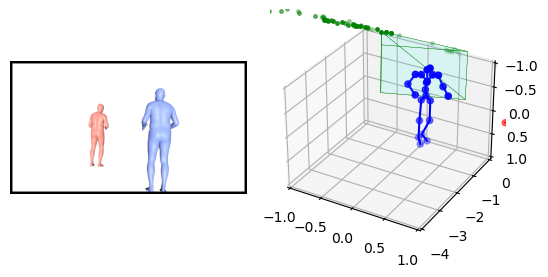

67
result: [-1.62918833  0.5226769   2.7214323 ]
141.0201189643485
result: [-1.62918833  0.5226769   2.7214323 ]


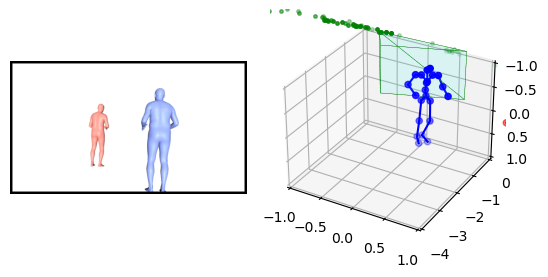

68
result: [-1.59543226  0.53716243  2.74776467]
141.52914871220906
result: [-1.59543226  0.53716243  2.74776467]


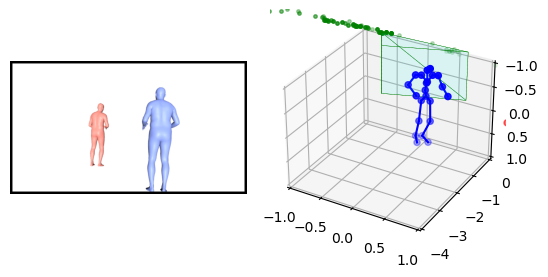

69
result: [-1.4899819   0.56590745  2.82008719]
143.24903625326496
result: [-1.4899819   0.56590745  2.82008719]


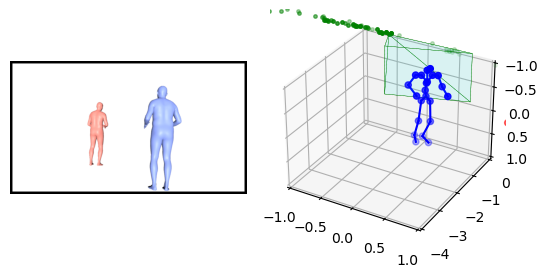

70
result: [-1.30123641  0.60869188  2.93328875]
146.23025050933745
result: [-1.30123641  0.60869188  2.93328875]


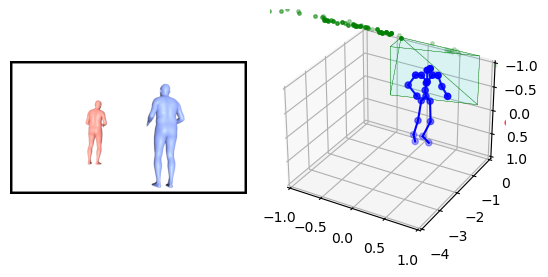

71
result: [-1.02637098  0.66350056  3.06820449]
150.28147845385138
result: [-1.02637098  0.66350056  3.06820449]


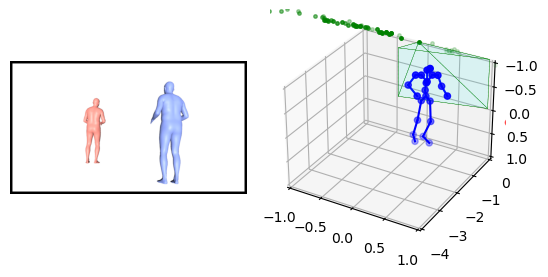

72
result: [-0.69716227  0.72123125  3.19021444]
154.7096775901278
result: [-0.69716227  0.72123125  3.19021444]


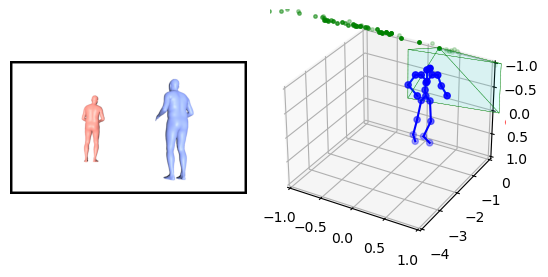

73
result: [-0.37874149  0.76956422  3.27266916]
158.55738249666933
result: [-0.37874149  0.76956422  3.27266916]


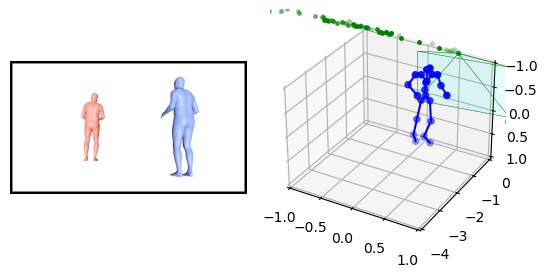

74
result: [-0.12357326  0.80328814  3.31621601]
161.28305443295642
result: [-0.12357326  0.80328814  3.31621601]


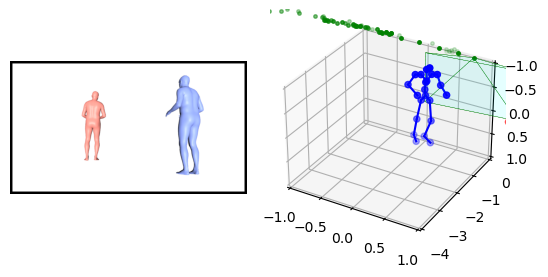

75
result: [0.04635071 0.82419382 3.33538552]
162.8585684028522
result: [0.04635071 0.82419382 3.33538552]


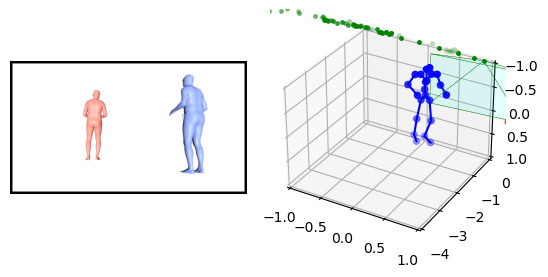

76
result: [0.10645858 0.83360944 3.34281233]
163.2965162416156
result: [0.10645858 0.83360944 3.34281233]


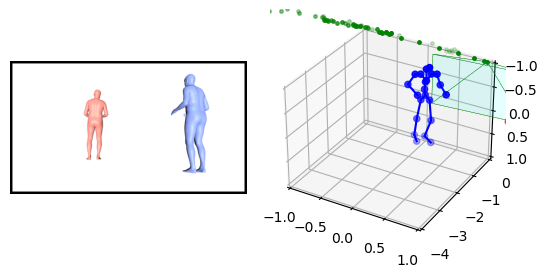

77
result: [0.06947371 0.83496632 3.34604274]
162.82711613098408
result: [0.06947371 0.83496632 3.34604274]


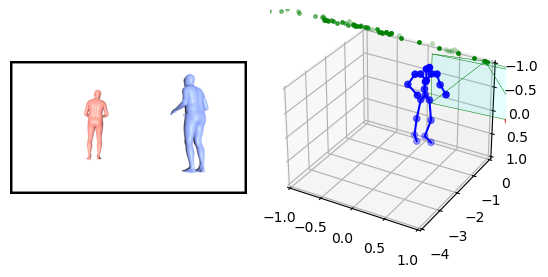

78
result: [0.05055846 0.83955063 3.35084095]
162.4763801242541
result: [0.05055846 0.83955063 3.35084095]


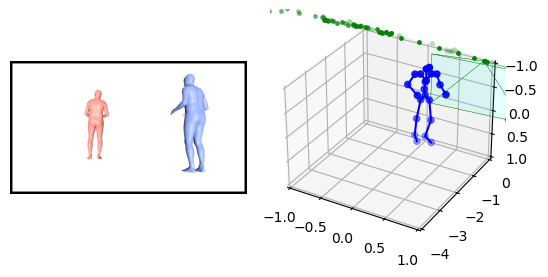

79
result: [0.16059766 0.85565038 3.36082167]
163.28657472181135
result: [0.16059766 0.85565038 3.36082167]


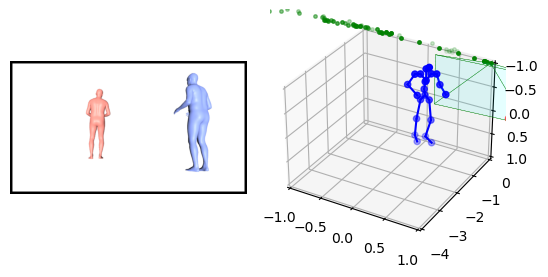

80
result: [0.39619079 0.87925909 3.36278061]
164.86705639852823
result: [0.39619079 0.87925909 3.36278061]


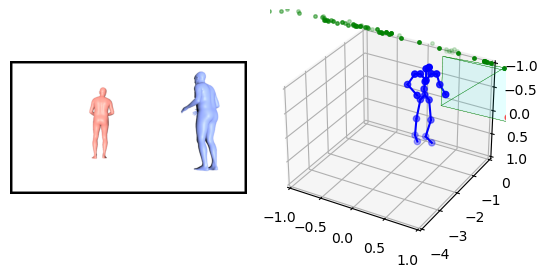

81
result: [0.67808941 0.90182195 3.34324108]
165.90146338494088
result: [0.67808941 0.90182195 3.34324108]


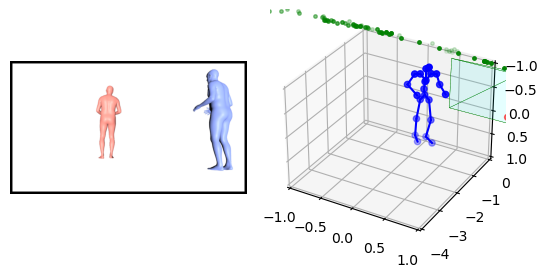

82
result: [0.92431796 0.91780291 3.30995711]
165.82556585535528
result: [0.92431796 0.91780291 3.30995711]


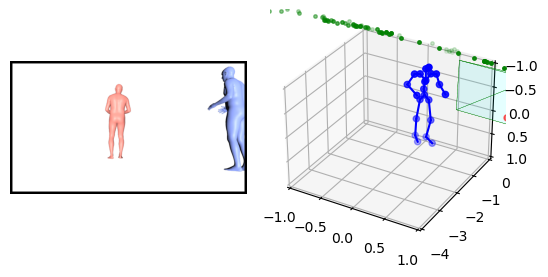

83
result: [1.10419861 0.92684256 3.27836833]
165.19567779015682
result: [1.10419861 0.92684256 3.27836833]


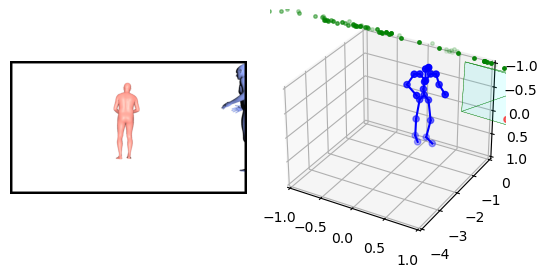

84
result: [1.22867081 0.9314577  3.25412055]
164.52452697556078
result: [1.22867081 0.9314577  3.25412055]


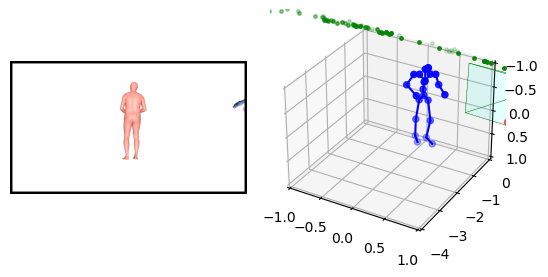

85
result: [1.29433387 0.93381537 3.24296369]
164.10911675228496
result: [1.29433387 0.93381537 3.24296369]


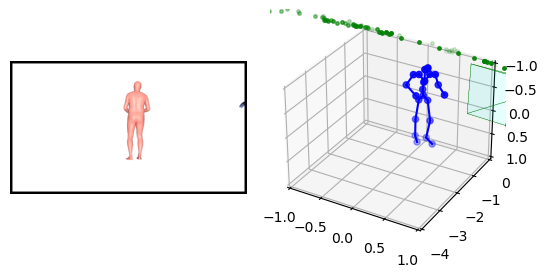

86
result: [1.3264871  0.93529643 3.24022688]
163.8952845954688
result: [1.3264871  0.93529643 3.24022688]


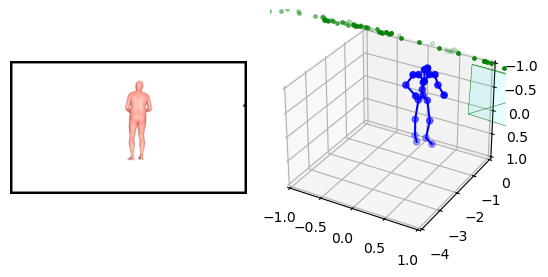

87
result: [1.4281615  0.93608107 3.21353759]
163.11493036923005
result: [1.4281615  0.93608107 3.21353759]


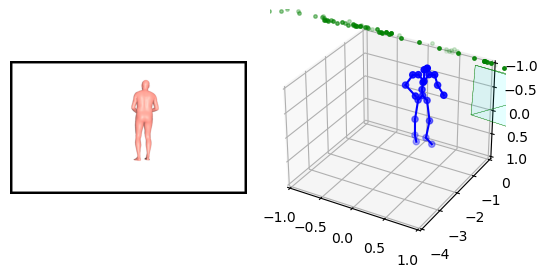

88
result: [1.6668742  0.93284999 3.12922632]
160.8192257318308
result: [1.6668742  0.93284999 3.12922632]


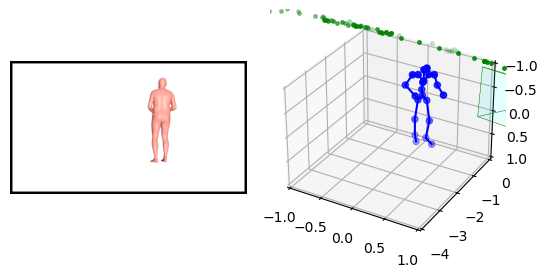

89
result: [2.01886935 0.91905932 2.96624143]
156.45018218759168
result: [2.01886935 0.91905932 2.96624143]


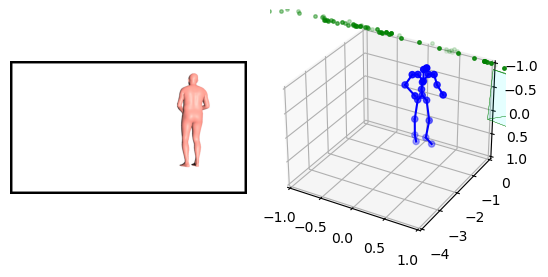

90
result: [2.41574961 0.89074178 2.72211655]
150.33227188615007
result: [2.41574961 0.89074178 2.72211655]


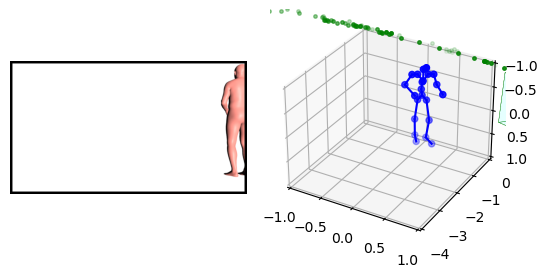

91
result: [2.75784646 0.85392359 2.44957368]
144.0373401942992
result: [2.75784646 0.85392359 2.44957368]


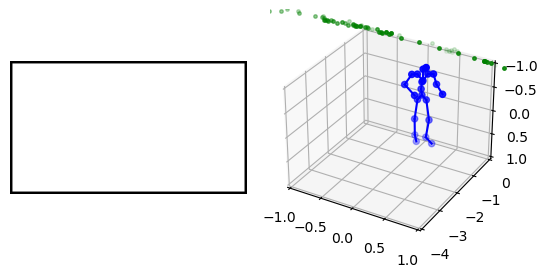

92
result: [2.98632386 0.82110457 2.22852061]
139.2004992895029
result: [2.98632386 0.82110457 2.22852061]


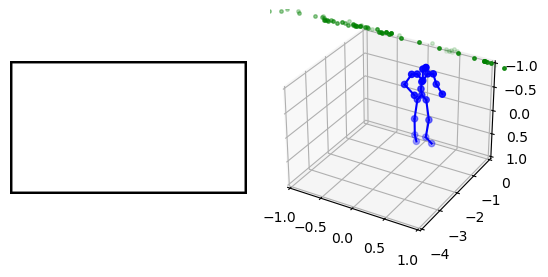

93
result: [3.14436036 0.7927972  2.05487277]
135.4786549179191
result: [3.14436036 0.7927972  2.05487277]


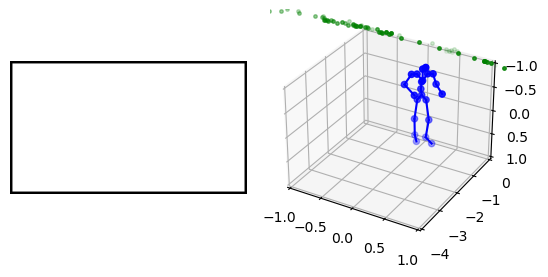

94
result: [3.31000359 0.75656486 1.84687254]
131.14460864296723
result: [3.31000359 0.75656486 1.84687254]


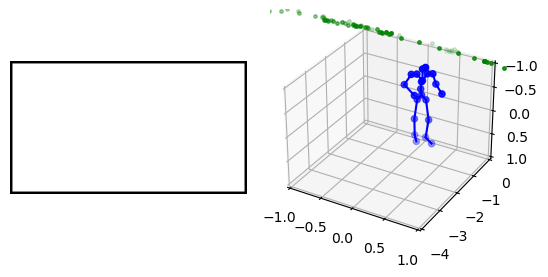

95
result: [3.51463297 0.69975869 1.53543784]
124.93968832968844
result: [3.51463297 0.69975869 1.53543784]


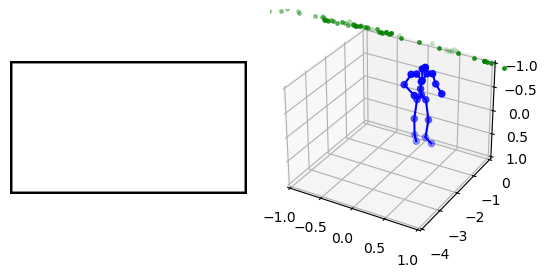

96
result: [3.72856839 0.61641125 1.11002994]
116.80337715158393
result: [3.72856839 0.61641125 1.11002994]


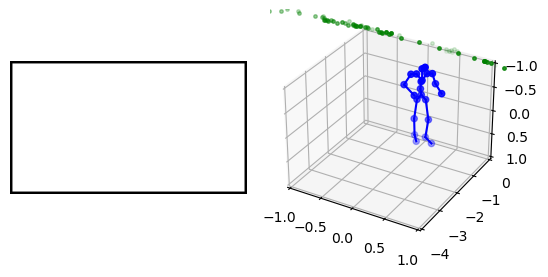

97
result: [3.89423896 0.51454634 0.63947525]
108.02488923100339
result: [3.89423896 0.51454634 0.63947525]


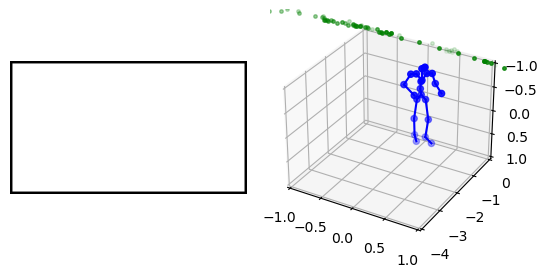

98
result: [3.98569983 0.41647093 0.23459677]
100.50720064845646
result: [3.98569983 0.41647093 0.23459677]


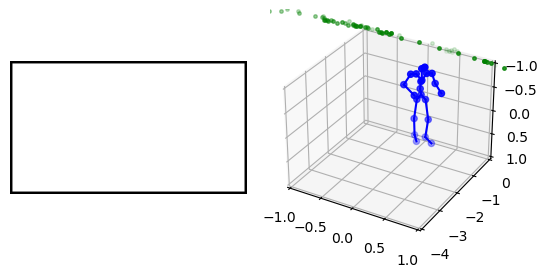

99
result: [ 4.02664059  0.33404246 -0.07007141]
94.77481332431978
result: [ 4.02664059  0.33404246 -0.07007141]


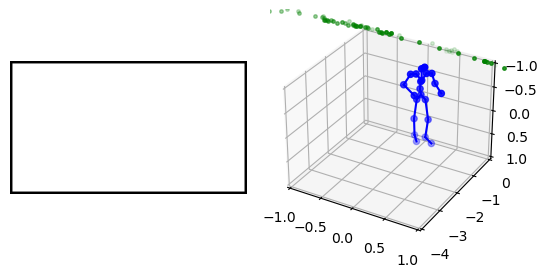

100
result: [ 4.04364764  0.25584736 -0.3376045 ]
89.645101395859
result: [ 4.04364764  0.25584736 -0.3376045 ]


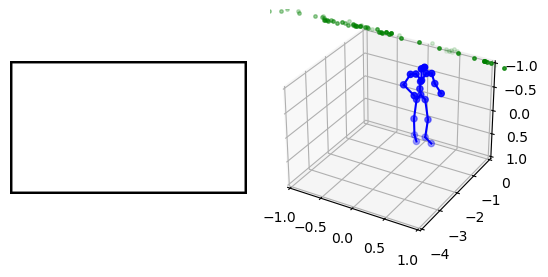

101
result: [ 4.04174251  0.16937586 -0.61856733]
84.18372266613932
result: [ 4.04174251  0.16937586 -0.61856733]


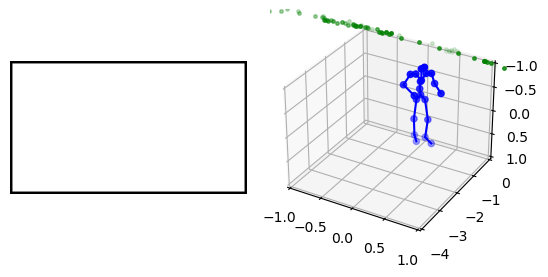

102
result: [ 4.01611531  0.07251585 -0.92115138]
78.24841718801939
result: [ 4.01611531  0.07251585 -0.92115138]


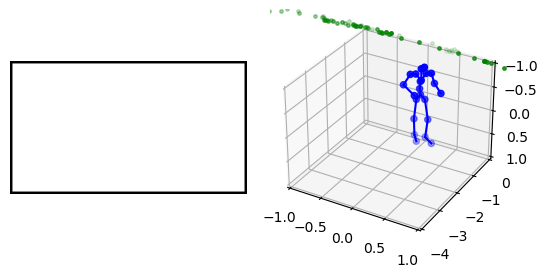

103
result: [ 3.95752002 -0.03341445 -1.25477041]
71.70952317603975
result: [ 3.95752002 -0.03341445 -1.25477041]


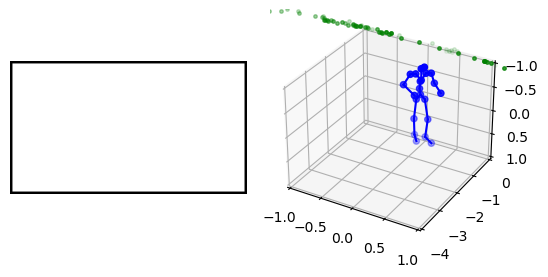

104
result: [ 3.8666479  -0.1357329  -1.58591911]
65.22695104026536
result: [ 3.8666479  -0.1357329  -1.58591911]


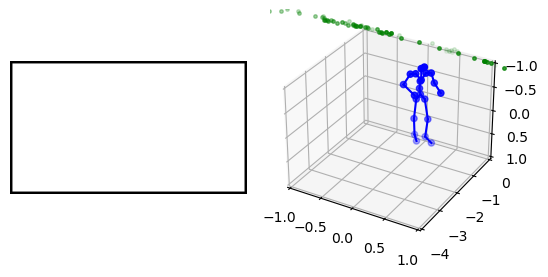

105
result: [ 3.76535187 -0.22025048 -1.86196701]
59.78085387267992
result: [ 3.76535187 -0.22025048 -1.86196701]


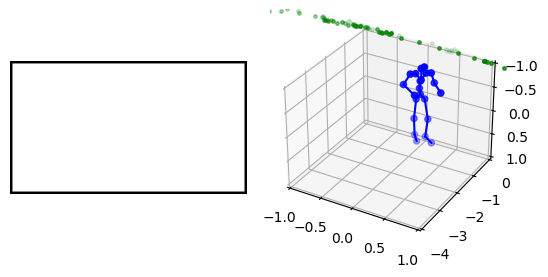

106
result: [ 3.65494619 -0.29396023 -2.10629131]
54.92057765044684
result: [ 3.65494619 -0.29396023 -2.10629131]


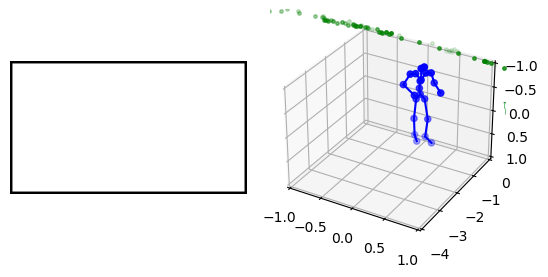

107
result: [ 3.51040296 -0.37101405 -2.37134368]
49.63075882198941
result: [ 3.51040296 -0.37101405 -2.37134368]


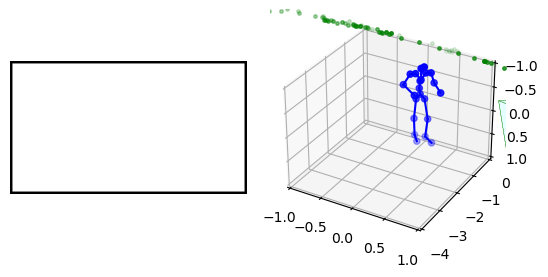

108
result: [ 3.33036597 -0.44902785 -2.64651851]
44.07771036370646
result: [ 3.33036597 -0.44902785 -2.64651851]


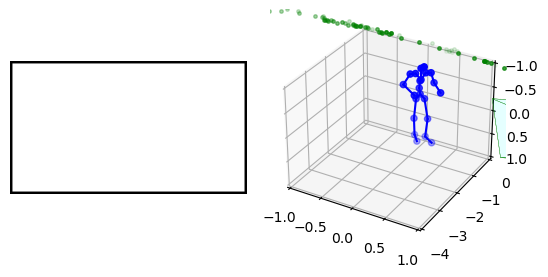

109
result: [ 3.13374618 -0.51943498 -2.90006431]
38.87290917361212
result: [ 3.13374618 -0.51943498 -2.90006431]


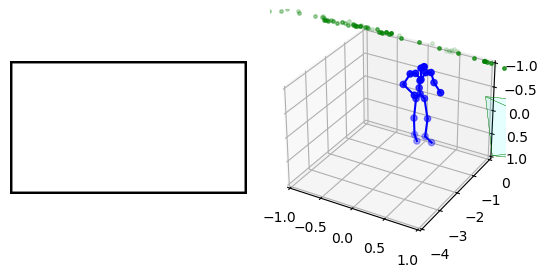

110
result: [ 2.92806405 -0.58050638 -3.12623525]
34.16042980390133
result: [ 2.92806405 -0.58050638 -3.12623525]


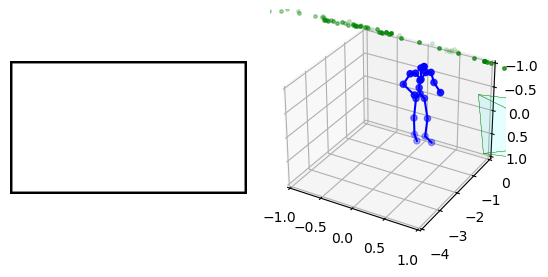

111
result: [ 2.73488977 -0.62984178 -3.30989044]
30.27816888078406
result: [ 2.73488977 -0.62984178 -3.30989044]


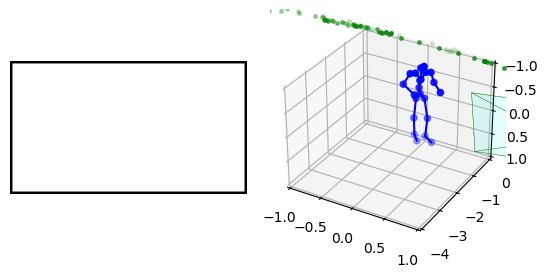

112
result: [ 2.59627823 -0.66438284 -3.42793796]
27.739702533850824
result: [ 2.59627823 -0.66438284 -3.42793796]


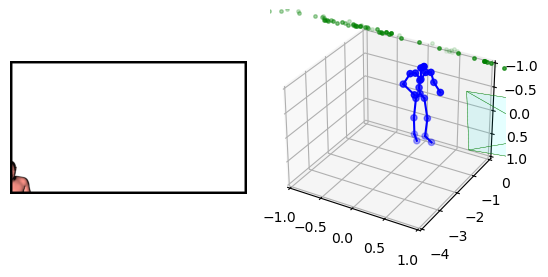

113
result: [ 2.51208884 -0.69049519 -3.49597402]
26.242856295093667
result: [ 2.51208884 -0.69049519 -3.49597402]


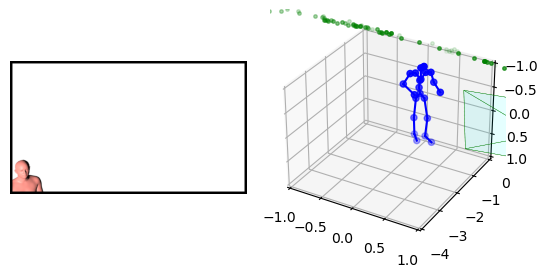

114
result: [ 2.41466968 -0.72388543 -3.57147914]
24.57435455210123
result: [ 2.41466968 -0.72388543 -3.57147914]


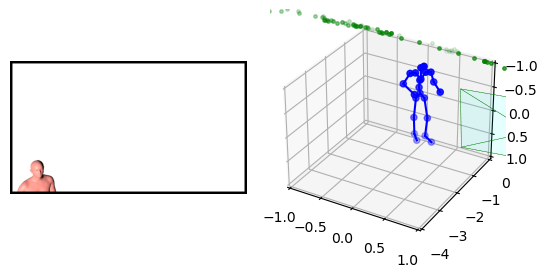

115
result: [ 2.26861002 -0.76629813 -3.67532019]
22.327916539186948
result: [ 2.26861002 -0.76629813 -3.67532019]


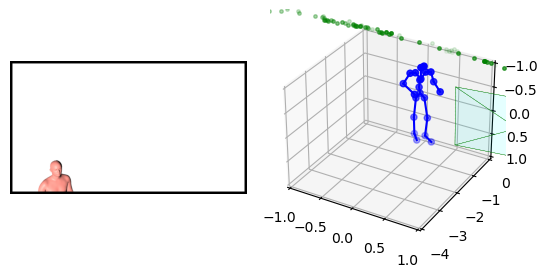

116
result: [ 2.11538614 -0.80286074 -3.773585  ]
20.261479375090435
result: [ 2.11538614 -0.80286074 -3.773585  ]


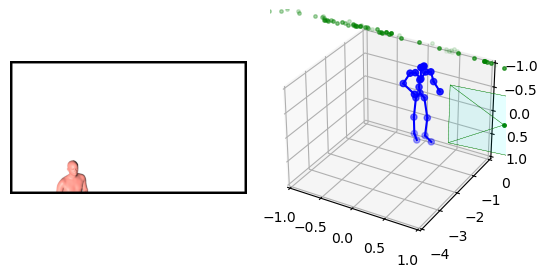

117
result: [ 2.01673791 -0.82104141 -3.83159454]
19.07498576461253
result: [ 2.01673791 -0.82104141 -3.83159454]


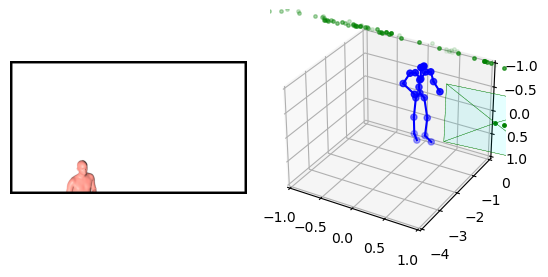

118
result: [ 1.98148121 -0.82459738 -3.85129711]
18.674443095583168
result: [ 1.98148121 -0.82459738 -3.85129711]


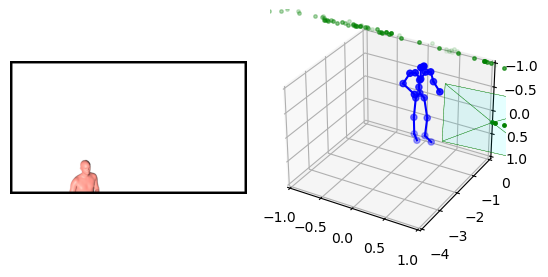

119
result: [ 2.01674295 -0.8210404  -3.83159161]
19.075044640761593
result: [ 2.01674295 -0.8210404  -3.83159161]


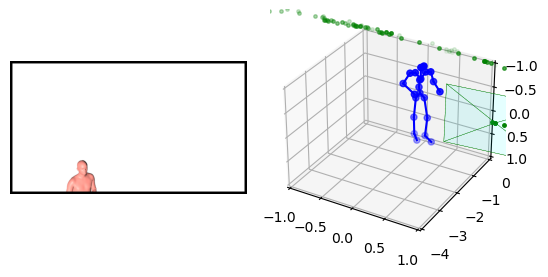

120


In [9]:
#Plot frame by frame
# left_joints_array = np.load("../Camera/generated_data/joint_cvt/0_p0_p0.npy")
# right_joints_array = np.load("../Camera/generated_data/joint_cvt/0_p0_p1.npy")
camera_array = np.load("../Camera/generated_data/camera/0.npy")
keys_to_convert = ['L2Dx', 'L2Dy', 'R2Dx', 'R2Dy', 'Theta', 'Phi']
desired_resolution = (960, 540)
dpi = 400  # Adjust the DPI to your needs
index = 0
camera_path = []
rotation_up = None



#遍历每一帧
for i in range(0,len(camera_array)):
    #i=119
    Camera_dic={}
    Camera = np.load("../Camera/generated_data/camera/0.npy")[i]
    for j, key in enumerate(keys_to_convert):
        Camera_dic[key] = float(Camera[j])    
    Camera_dic["FOV"] = 45 #相机水平视野 FOV=45°
    Camera_dic["Aspect"] = 1.67
    
    Camera_dic["L2Dx"] = 0.5
    Camera_dic["L2Dy"] = 0.5
    Camera_dic["R2Dx"] = -0.5
    Camera_dic["R2Dy"] = 0.5
    
    cam_angle = angle_between(np.array([Camera_dic["R2Dx"]-Camera_dic["L2Dx"], Camera_dic["R2Dy"]-Camera_dic["L2Dy"]]), 
                  np.array([1,0]))
    
    
    alpha = get_alpha(Camera_dic["FOV"], Camera_dic["Aspect"],
                [Camera_dic["L2Dx"], Camera_dic["L2Dy"]], [Camera_dic["R2Dx"], Camera_dic["R2Dy"]])
    
    Camera_dic["Theta"] = np.pi-alpha
    Camera_dic["Phi"] = -np.pi/12
    
    # Load and Preprocess Joints    
    left_joints = np.load("../Camera/generated_data/joint_cvt/0_p0_p0.npy")[i]
    right_joints = np.load("../Camera/generated_data/joint_cvt/0_p0_p1.npy")[i]
    # 交换 Y/Z 维度
    left_joints[:,[1,2]]=left_joints[:,[2,1]]
    right_joints[:,[1,2]]=right_joints[:,[2,1]]
    # Y 轴取反
    left_joints[:,1]*=-1
    right_joints[:,1]*=-1
    #left_joints[:,2] *=   -1
    #right_joints[:,2] *=   -1

    #新建场景与刚体预处理
    scene = pyrender.Scene()
    for i, joint_position in enumerate(left_joints):
        left_joints[i][0] *= 1 
        left_joints[i][1] *= 1 
        left_joints[i][2] *= 1 
                # left_joints[i] -= new_system_origin

    for i, joint_position in enumerate(right_joints):
        right_joints[i][0] *= 1
        right_joints[i][1] *= 1 
        right_joints[i][2] *= 1 
                # right_joints[i] -= new_system_origin

    #设置相机节点及位姿
    camera = pyrender.PerspectiveCamera(yfov=np.deg2rad(45), aspectRatio=1.67)
            # Camera position and orientation
    cam_pose = np.array([
                [-1.0, 0.0, 0.0],
                [0.0, -1.0, 0.0],
                [0.0, 0.0, -1.0],
            ])
            # print(left_joints[15])
            # print(right_joints[15])
            # print(Camera_dic)

     #确定“观看目标”点
    if (left_joints[15] == right_joints[15]).all():
        left_person = left_joints[17]
        right_person = left_joints[16]
        left = left_person if left_person[0] < right_person[0] else right_person
        right = right_person if left_person[0] < right_person[0] else left_person
    else:
        left = left_joints[15]
        right = right_joints[15]
    new_camera_pos = toric2euclidean(Camera_dic, left, right)
    look_at_angle = angle_between(np.array([0.0, 0.0, 1.0]), (left+right)/2-new_camera_pos)

    #应用位姿并添加到场景
    cam_new_pose = np.eye(4)
    cam_new_pose[:3, :3] = cam_pose #@rotation_matrix_x(-Camera_dic["Phi"]/2)@rotation_matrix_y(-look_at_angle)
    cam_new_pose[:3, 3] = new_camera_pos
    camera_node = scene.add(camera, pose=cam_new_pose)
        # cam_new_pose[:3, 3] = np.array([0.0,0.0,0.0]) - new_system_origin
    #print(new_camera_pos)
            # print(new_system_origin)
            # print(new_camera_pos, "----------", np.array([0.0,0.0,0.0]) - new_system_origin)

            # Add the camera to the scene

    #进一步绕局部轴旋转
    pose = camera_node.matrix  
    angle_deg = look_at_angle/np.pi*180
    print(angle_deg)
    rot_local = R.from_euler('y', angle_deg, degrees=True).as_matrix()
    rot_local_4x4 = np.eye(4)
    rot_local_4x4[:3, :3] = rot_local
    new_pose = pose @ rot_local_4x4  
    scene.set_pose(camera_node, new_pose)
    
    #Local Camera Rotations
    pose = camera_node.matrix  
    rot_local = R.from_euler('x', Camera_dic["Phi"]/2, degrees=True).as_matrix()
    rot_local_4x4 = np.eye(4)
    rot_local_4x4[:3, :3] = rot_local
    new_pose = pose @ rot_local_4x4  
    scene.set_pose(camera_node, new_pose)     
    
    #添加光源
    light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=5.0)
    scene.add(light, pose=new_pose)
    
    
    human_angle = np.pi / 2  # 90 degrees
    human_rotation_x = trimesh.transformations.rotation_matrix(
                    human_angle, direction=[1, 0, 0], point=[0, 0, 0]
                    )

    #加载人物网格并放入场景

    p1_mesh = trimesh.load('joints2smpl-main/demo/demo_results/0_p0_p0/0119.ply')
    p2_mesh = trimesh.load('joints2smpl-main/demo/demo_results/0_p0_p1/0119.ply')
    material_1 = pyrender.MetallicRoughnessMaterial(baseColorFactor=[1.0, 0.4, 0.3, 1.0],  # 颜色
                                                    metallicFactor=0.0,                
                                                    roughnessFactor=0.5 )
    material_2 = pyrender.MetallicRoughnessMaterial(baseColorFactor=[0.25, 0.3, 1.0, 1.0],  # 颜色
                                                    metallicFactor=0.0,                
                                                    roughnessFactor=0.5)
    pyrender_mesh_p1 = pyrender.Mesh.from_trimesh(p1_mesh, material=material_1)
    pyrender_mesh_p2 = pyrender.Mesh.from_trimesh(p2_mesh, material=material_2)
    scene.add(pyrender_mesh_p1,pose=human_rotation_x)
    scene.add(pyrender_mesh_p2,pose=human_rotation_x)

    #绘制关节（球体）与骨骼（圆柱）
    # material = pyrender.MetallicRoughnessMaterial(baseColorFactor=[0.0, 0.0, 1.0, 1.0])
    # for i, joint_position in enumerate(right_joints):
    #             # right_joints[i][0] *= 1 / 1000
    #             # right_joints[i][1] *= 1 / 1000
    #             # right_joints[i][2] *= 1 / 1000
    #             # right_joints[i] -= new_system_origin
    #     joint_mesh = trimesh.creation.icosphere(radius=0.03, subdivisions=2)
    #     joint_mesh.apply_translation(right_joints[i])
    #     scene.add(pyrender.Mesh.from_trimesh(joint_mesh, material=material))
    #             # print(right_joints[i])
    # for connection in connections:
    #             # print(connection[0], connection[1])
    #             # print(right_joints[connection[0]], right_joints[connection[1]])
    #     cylinder = create_cylinder_between_points(right_joints[connection[0]], right_joints[connection[1]], 0.01)
    #     scene.add(pyrender.Mesh.from_trimesh(cylinder, material=material))

    if rotation_up is None:
        spine_up = right_joints[9] - right_joints[6]
        spine_up /= np.linalg.norm(spine_up)
        original_up = np.array([0.0, -1.0, 0.0])
        spine_up = original_up
        rotation_axis = np.cross(spine_up, original_up)
        angle = np.arccos(np.dot(original_up, spine_up))
        rotation_vector = rotation_axis * angle
        rotation_up = R.from_rotvec(rotation_vector)
                # print(angle)

    for i, joint_position in enumerate(right_joints):
        right_joints[i] = rotation_up.apply(joint_position)

    # material = pyrender.MetallicRoughnessMaterial(baseColorFactor=[1.0, 0.0, 0.0, 1.0])
    # for i, joint_position in enumerate(left_joints):
    #             # left_joints[i][0] *= 1 / 1000
    #             # left_joints[i][1] *= 1 / 1000
    #             # left_joints[i][2] *= 1 / 1000
    #             # left_joints[i] -= new_system_origin
    #     joint_mesh = trimesh.creation.icosphere(radius=0.03, subdivisions=2)
    #     joint_mesh.apply_translation(left_joints[i])
    #     scene.add(pyrender.Mesh.from_trimesh(joint_mesh, material=material))
    #             # left_joints[i] = np.dot(rotation, left_joints[i])
    #             # joint_mesh = trimesh.creation.icosphere(radius=0.03, subdivisions=2)
    #             # joint_mesh.apply_translation(np.dot(rotation, left_joints[i] - new_system_origin))
    #             # scene.add(pyrender.Mesh.from_trimesh(joint_mesh, material = material))
    # for connection in connections:
    #     cylinder = create_cylinder_between_points(left_joints[connection[0]], left_joints[connection[1]], 0.01)
    #     scene.add(pyrender.Mesh.from_trimesh(cylinder, material=material))

    # for i, joint_position in enumerate(left_joints):
    #     left_joints[i] = rotation_up.apply(joint_position)

            # Set up the renderer with a specific resolution

    # 离屏渲染并后处理
    renderer = pyrender.OffscreenRenderer(viewport_width=960, viewport_height=540)

            # Render the scene
    color, depth = renderer.render(scene)

            # Define the thickness of the frame border
    border_thickness = 10  # Adjust this value to your preference
    color = np.array(color)
    color = np.flip(color)

            # Create the black frame by manipulating the color array
            # Set the border rows and columns to black
    color[:border_thickness, :, :] = 0  # Top border
    color[-border_thickness:, :, :] = 0  # Bottom border
    color[:, :border_thickness, :] = 0  # Left border
    color[:, -border_thickness:, :] = 0  # Right border

    #可视化
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ## 左子图：渲染图像
    ax2 = fig.add_subplot(121)
    ax2.imshow(color)
    ax2.axis('off')
    ## 右子图：3D 骨骼 + 相机轨迹
    ax = fig.add_subplot(122, projection='3d')
    ax.set_aspect('auto')
    x_limits = [-1, 1]
    y_limits = [-4, 0]
    z_limits = [1, -1]

    ax.set_xlim(x_limits)
    ax.set_zlim(z_limits)
    ax.set_ylim(y_limits)

    ax.plot(right_joints[:2, 0], right_joints[:2, 2], right_joints[:2, 1], c="red")
    ax.plot(right_joints[:3:2, 0], right_joints[:3:2, 2], right_joints[:3:2, 1], c="red")
    ax.plot(right_joints[:4:3, 0], right_joints[:4:3, 2], right_joints[:4:3, 1], c="red")
    ax.plot(right_joints[1:5:3, 0], right_joints[1:5:3, 2], right_joints[1:5:3, 1], c="red")
    ax.plot(right_joints[2:6:3, 0], right_joints[2:6:3, 2], right_joints[2:6:3, 1], c="red")
    ax.plot(right_joints[3:7:3, 0], right_joints[3:7:3, 2], right_joints[3:7:3, 1], c="red")
    ax.plot(right_joints[4:8:3, 0], right_joints[4:8:3, 2], right_joints[4:8:3, 1], c="red")
    ax.plot(right_joints[5:9:3, 0], right_joints[5:9:3, 2], right_joints[5:9:3, 1], c="red")
    ax.plot(right_joints[6:10:3, 0], right_joints[6:10:3, 2], right_joints[6:10:3, 1], c="red")
    ax.plot(right_joints[7:11:3, 0], right_joints[7:11:3, 2], right_joints[7:11:3, 1], c="red")
    ax.plot(right_joints[8:12:3, 0], right_joints[8:12:3, 2], right_joints[8:12:3, 1], c="red")
    ax.plot(right_joints[9:13:3, 0], right_joints[9:13:3, 2], right_joints[9:13:3, 1], c="red")
    ax.plot(right_joints[9:14:4, 0], right_joints[9:14:4, 2], right_joints[9:14:4, 1], c="red")
    ax.plot(right_joints[9:15:5, 0], right_joints[9:15:5, 2], right_joints[9:15:5, 1], c="red")
    ax.plot(right_joints[12:16:3, 0], right_joints[12:16:3, 2], right_joints[12:16:3, 1], c="red")
    ax.plot(right_joints[14:18:3, 0], right_joints[14:18:3, 2], right_joints[14:18:3, 1], c="red")
    ax.plot(right_joints[13:17:3, 0], right_joints[13:17:3, 2], right_joints[13:17:3, 1], c="red")
    ax.plot(right_joints[16:19:2, 0], right_joints[16:19:2, 2], right_joints[16:19:2, 1], c="red")
    ax.plot(right_joints[17:20:2, 0], right_joints[17:20:2, 2], right_joints[17:20:2, 1], c="red")
    ax.plot(right_joints[18:21:2, 0], right_joints[18:21:2, 2], right_joints[18:21:2, 1], c="red")
    ax.plot(right_joints[19:22:2, 0], right_joints[19:22:2, 2], right_joints[19:22:2, 1], c="red")
    ax.plot(right_joints[20:23:2, 0], right_joints[20:23:2, 2], right_joints[20:23:2, 1], c="red")
    ax.plot(right_joints[21:24:2, 0], right_joints[21:24:2, 2], right_joints[21:24:2, 1], c="red")
    if (left_joints[15] != right_joints[15]).all():
        ax.plot(left_joints[:2, 0], left_joints[:2, 2], left_joints[:2, 1], c="blue")
        ax.plot(left_joints[:3:2, 0], left_joints[:3:2, 2], left_joints[:3:2, 1], c="blue")
        ax.plot(left_joints[:4:3, 0], left_joints[:4:3, 2], left_joints[:4:3, 1], c="blue")
        ax.plot(left_joints[1:5:3, 0], left_joints[1:5:3, 2], left_joints[1:5:3, 1], c="blue")
        ax.plot(left_joints[2:6:3, 0], left_joints[2:6:3, 2], left_joints[2:6:3, 1], c="blue")
        ax.plot(left_joints[3:7:3, 0], left_joints[3:7:3, 2], left_joints[3:7:3, 1], c="blue")
        ax.plot(left_joints[4:8:3, 0], left_joints[4:8:3, 2], left_joints[4:8:3, 1], c="blue")
        ax.plot(left_joints[5:9:3, 0], left_joints[5:9:3, 2], left_joints[5:9:3, 1], c="blue")
        ax.plot(left_joints[6:10:3, 0], left_joints[6:10:3, 2], left_joints[6:10:3, 1], c="blue")
        ax.plot(left_joints[7:11:3, 0], left_joints[7:11:3, 2], left_joints[7:11:3, 1], c="blue")
        ax.plot(left_joints[8:12:3, 0], left_joints[8:12:3, 2], left_joints[8:12:3, 1], c="blue")
        ax.plot(left_joints[9:13:3, 0], left_joints[9:13:3, 2], left_joints[9:13:3, 1], c="blue")
        ax.plot(left_joints[9:14:4, 0], left_joints[9:14:4, 2], left_joints[9:14:4, 1], c="blue")
        ax.plot(left_joints[9:15:5, 0], left_joints[9:15:5, 2], left_joints[9:15:5, 1], c="blue")
        ax.plot(left_joints[12:16:3, 0], left_joints[12:16:3, 2], left_joints[12:16:3, 1], c="blue")
        ax.plot(left_joints[14:18:3, 0], left_joints[14:18:3, 2], left_joints[14:18:3, 1], c="blue")
        ax.plot(left_joints[13:17:3, 0], left_joints[13:17:3, 2], left_joints[13:17:3, 1], c="blue")
        ax.plot(left_joints[16:19:2, 0], left_joints[16:19:2, 2], left_joints[16:19:2, 1], c="blue")
        ax.plot(left_joints[17:20:2, 0], left_joints[17:20:2, 2], left_joints[17:20:2, 1], c="blue")
        ax.plot(left_joints[18:21:2, 0], left_joints[18:21:2, 2], left_joints[18:21:2, 1], c="blue")
        ax.plot(left_joints[19:22:2, 0], left_joints[19:22:2, 2], left_joints[19:22:2, 1], c="blue")
        ax.plot(left_joints[20:23:2, 0], left_joints[20:23:2, 2], left_joints[20:23:2, 1], c="blue")
        ax.plot(left_joints[21:24:2, 0], left_joints[21:24:2, 2], left_joints[21:24:2, 1], c="blue")
        ax.scatter(left_joints[:24, 0], left_joints[:24, 2], left_joints[:24, 1], c="blue")
    ax.scatter(right_joints[:24, 0], right_joints[:24, 2], right_joints[:24, 1], c="red")
            # ax.scatter(left_joints[:24, 0], left_joints[:24, 2], left_joints[:24, 1], c="blue")

            # draw_camera_frustum(ax, [0.0, 0.0,0.0], cam_pose)
            # print(Camera_dic, left_joints[15], right_joints[15])
            # print(Camera_dic)
            # print(left_joints[15])
            # print(right_joints[15])
    new_camera_pos = toric2euclidean(Camera_dic, left, right)
            # print("dfff:",cam_new_pose[:3, 3])
            # print("ddfg:",left_joints[15], right_joints[15])

    origin_size = 25  # Size of the marker for the origin
            # camera_cur_pos = np.array([0.0, 0.0, 0.0]) - new_system_origin
    camera_cur_pos = new_camera_pos
            # print(camera_cur_pos)
            # assert 1==2
            # camera_cur_pos = np.dot(rotation_matrix, camera_cur_pos)
    camera_path.append(camera_cur_pos)
    for i, camera_pos in enumerate(camera_path):
        fade_value = (i + 1) / len(camera_path)
        rot_trans = toric2rotation(Camera_dic, np.array([camera_pos[0], camera_pos[1], camera_pos[2]]),
                                           left, right)
        camera_pos = rotation_up.apply(camera_pos)
                # print(camera_pos)
                # print(left_joints[15])
                # print(right_joints[15])
                # shot_type = predict_shot_type(camera_pos, left_joints[15], right_joints[15])   #判断景别
                # print(shot_type)
                # assert 1==2
        ax.scatter(camera_pos[0], camera_pos[2], camera_pos[1], color="green", marker='.', s=origin_size,
                           depthshade=True, alpha=fade_value)
        if i == len(camera_path) - 1:
            draw_camera_viewing_cone(ax, camera_cur_pos, rot_trans, rotation_up)

            # print(new_camera_pos, left_joints[3], right_joints[3])

    #保存与清理
    plt.subplots_adjust(wspace=0.1, hspace=0)
    #plt.savefig(f"frames/camera_2/{index}.jpg", dpi=dpi, bbox_inches='tight', pad_inches=0)
    plt.savefig(f"Visualize/0119.jpg", dpi=dpi, bbox_inches='tight', pad_inches=0)
    plt.show()
    
    file_name = "camera_frames"
    output_dir = f"Visualize/{file_name}"
    os.makedirs(output_dir, exist_ok=True)
    imageio.imwrite(f"{output_dir}/{index}.jpg", color)

    # imageio.imwrite(f"Visualize/{file_name}/{index}.jpg", color)
    index += 1
    print(index)
            # Clean up the renderer
    renderer.delete()

In [8]:
camera_array

array([[-3.86010153e-01,  4.46759143e-01,  2.61337800e-01,
         3.93396719e-01,  2.47041723e+00,  4.03646625e-02],
       [-4.22473495e-01,  4.64483160e-01,  2.24073720e-01,
         4.05439641e-01,  2.43431967e+00,  4.52581109e-02],
       [-4.06585511e-01,  4.41761428e-01,  2.29688229e-01,
         3.83838408e-01,  2.52506384e+00,  4.06722865e-02],
       [-4.47653950e-01,  4.26854263e-01,  2.24846587e-01,
         3.81841843e-01,  2.35960468e+00,  3.22083495e-02],
       [-4.47500841e-01,  4.04999979e-01,  2.00877345e-01,
         3.82386548e-01,  2.35108022e+00,  1.64451644e-02],
       [-4.35768832e-01,  4.00424077e-01,  1.76353164e-01,
         3.97300364e-01,  2.37233293e+00, -7.11013618e-03],
       [-4.55663112e-01,  3.75152246e-01,  1.36981570e-01,
         3.76861316e-01,  2.38657968e+00,  1.08643417e-03],
       [-4.47425314e-01,  3.65247079e-01,  1.40396480e-01,
         3.82080218e-01,  2.36344977e+00, -3.11218592e-02],
       [-4.26765778e-01,  3.67737287e-01,  1.140